In [1]:
!pip install pennylane
!python -m pip install pennylane-sf
!pip install nlopt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 24.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.3/48.3 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.5/16.5 MB 56.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 31.8 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 59.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.0/48.0 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.6/108.6 kB 7.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.2/117.2 kB 11.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.5/103.5 kB 10.8 MB/s eta 0:00:00

In [2]:
#!/usr/bin/env python3
import pennylane as qml
from pennylane import numpy as np
from pennylane.templates import RandomLayers
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

import strawberryfields as sf
import torch

# OpenMP: number of parallel threads.
%env OMP_NUM_THREADS=1

# Plotting
%matplotlib inline
import matplotlib.pyplot as plt

# Other tools
import time
import os
import copy


env: OMP_NUM_THREADS=1


In [3]:
np.random.seed(0)

# Dataset

In [4]:
def create_data_set(drop: float):
    np.random.seed(0)
    l = 150
    n = 2

    X1 = np.array([[-1, -1]]) + drop*np.random.randn(l, n)
    X2 = np.array([[1, 1]]) + drop*np.random.randn(l, n)

    #конкатенируем все в одну матрицу
    #при этом по 20 точек оставим на тест/валидацию
    X = np.vstack((X1[10:], X2[10:]))
    ValX = np.vstack((X1[:10], X2[:10]))

    #конкатенируем все в один столбец с соответствующими значениями для класса 0 или 1
    y = np.hstack([[0]*(l-10), [1]*(l-10)])
    ValY = np.hstack([[0]*10, [1]*10])

    visualize_dataset(X, y, ValX, ValY)

    return torch.tensor(X, requires_grad=False), torch.tensor(y, requires_grad=False), torch.tensor(ValX, requires_grad=False), torch.tensor(ValY, requires_grad=False)

In [5]:
def visualize_dataset(trainX, trainY, ValX, ValY)-> None:
    colors = ['blue', 'red', 'yellow', 'green']

    for k in np.unique(trainY):
        plt.plot(trainX[trainY==k, 0], trainX[trainY==k, 1], 'o', label='class {}'.format(k), color = colors[k])

    for k in np.unique(ValY):
        plt.plot(ValX[ValY==k, 0], ValX[ValY==k, 1], 'o', label='class {}'.format(k), color = colors[k+2])

    plt.legend(loc='best')
    plt.show()
    plt.close()

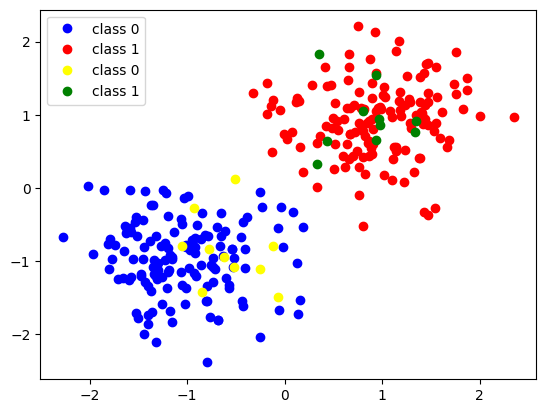

In [6]:
trainX, trainY, ValX, ValY = create_data_set(0.5)

# Model

In [106]:
shots = 500  # кол-во измерений для набора статистики
dev = qml.device("strawberryfields.fock", wires=2, cutoff_dim=5, shots=shots)

In [107]:
params_num = 8

def layer(params, sample):
    for j in range(2):
        qml.Squeezing(1.5, sample[j], wires=j)
    
    qml.Beamsplitter(params[0], params[1], wires=[0, 1])
    qml.Rotation(params[2], wires=0)
    qml.Rotation(params[3], wires=1)
    # Dgate(r, phi=0.0)
    qml.Displacement(params[4], 0.0, wires=0)
    qml.Displacement(params[5], 0.0, wires=1)
    qml.Kerr(params[6], wires=0)
    qml.Kerr(params[7], wires=1)


@qml.qnode(dev, interface='torch')
def circuit_0(params, sample):
    layer(params, sample)
    return qml.expval(op=qml.FockStateProjector(torch.tensor([2,0], requires_grad=False), wires=[0,1]))


@qml.qnode(dev, interface='torch')
def circuit_1(params, sample):
    layer(params, sample)
    return qml.expval(op=qml.FockStateProjector(torch.tensor([0,2], requires_grad=False), wires=[0,1]))


def classifier(params, x):
    o0 = circuit_0(params,x)
    o1 = circuit_1(params,x)
    p0 = o0/(o0+o1)
    return p0  # , 1-p0

In [123]:
def square_loss(labels, predictions):
    loss = torch.sum((labels - torch.absolute(predictions)) ** 2) / labels.size(dim=0)
    # print(loss)
    return loss

def log_loss(labels, predictions):
    loss = - torch.sum(labels * torch.log(predictions) + (1 - labels)*torch.log(1 - predictions))

    return loss

# def accuracy(labels, predictions):
#     acc = np.sum(np.where(np.abs(labels - predictions) < 1e-5, 1, 0))
#     return acc

# def square_loss(labels, predictions):
#     loss = 0
#     print(f'predictions: {predictions}')
#     for l, p in zip(labels, np.absolute(predictions)):
#         loss = loss + (l - p) ** 2
#     loss = loss / len(labels)
#     print(loss)
#     return loss

def accuracy(labels, predictions):
    acc = 0
    pred = torch.round(predictions)
    for l, p in zip(labels, torch.absolute(pred)):
        if abs(l - p) < 1e-5:
            acc = acc + 1
    acc = acc / labels.size(dim=0)
    return acc

In [124]:
def cost(var, data_input, labels):
    predictions = torch.tensor([classifier(var, x) for x in data_input], requires_grad=True)
    loss = torch.absolute(square_loss(labels, predictions))
    # loss = torch.absolute(log_loss(labels, predictions)) 
    
    return loss

In [125]:
train_loss_history, train_acc_history = [], []
val_loss_history, val_acc_history = [], []

var = torch.tensor([0.5]*params_num, requires_grad=True)
steps = 40

opt = torch.optim.SGD([var], lr = 0.035)

def closure(params, train, gt):
    opt.zero_grad()
    loss = cost(params, train, gt)
    # print(loss)
    loss.backward()
    # print(params.grad)
    return loss

for step in range(steps):
    opt.step(lambda: closure(var, trainX, trainY))

    predictions = torch.tensor([classifier(var, x) for x in ValX], requires_grad=False)
    val_accuracy = accuracy(ValY, np.round(predictions))
    val_loss = square_loss(ValY, predictions)

    predictions = torch.tensor([classifier(var, x) for x in trainX], requires_grad=False)
    train_accuracy = accuracy(trainY, np.round(predictions))
    train_loss = square_loss(trainY, predictions)

    train_loss_history.append(train_loss)
    train_acc_history.append(train_accuracy)
    val_loss_history.append(val_loss)
    val_acc_history.append(val_accuracy)

    # if (step+1) % 5 == 0:
    print(f"Iter: {step+1:5d} | Train Loss: {train_loss:0.7f} | Train accuracy: {train_accuracy} | Val Loss: {val_loss:0.7f} | Val_accuracy: {val_accuracy} ")

Iter:     1 | Train Loss: 1257.2146091 | Train accuracy: 0.3357142857142857 | Val Loss: 3.4065840 | Val_accuracy: 0.35 
Iter:     2 | Train Loss: 2.1498255 | Train accuracy: 0.375 | Val Loss: 0.3685076 | Val_accuracy: 0.3 
Iter:     3 | Train Loss: 4.8573185 | Train accuracy: 0.3535714285714286 | Val Loss: 0.3561503 | Val_accuracy: 0.35 
Iter:     4 | Train Loss: 1.4015515 | Train accuracy: 0.37857142857142856 | Val Loss: 0.3632301 | Val_accuracy: 0.35 
Iter:     5 | Train Loss: 0.5777375 | Train accuracy: 0.3392857142857143 | Val Loss: 0.3018002 | Val_accuracy: 0.45 
Iter:     6 | Train Loss: 12.8845355 | Train accuracy: 0.33214285714285713 | Val Loss: 0.2933671 | Val_accuracy: 0.4 
Iter:     7 | Train Loss: 17.1207826 | Train accuracy: 0.3 | Val Loss: 0.3604682 | Val_accuracy: 0.35 
Iter:     8 | Train Loss: 1.4231191 | Train accuracy: 0.35 | Val Loss: 0.4411394 | Val_accuracy: 0.25 
Iter:     9 | Train Loss: 0.8793533 | Train accuracy: 0.3607142857142857 | Val Loss: 1.1981569 | Val_

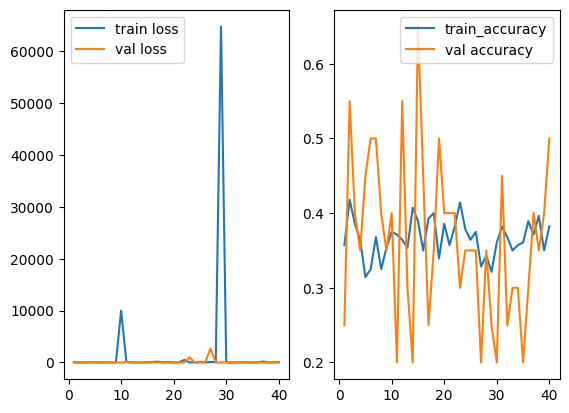

In [87]:
fig, axs = plt.subplots(nrows=1, ncols=2)

axs[0].plot(range(1, steps+1), train_loss_history, label='train loss')
axs[0].plot(range(1, steps+1), val_loss_history, label='val loss')
# axs[0].
axs[0].legend()

axs[1].plot(range(1, steps+1), train_acc_history, label='train_accuracy')
axs[1].plot(range(1, steps+1), val_acc_history, label='val accuracy')
axs[1].legend()

plt.show()

In [ ]:
qml.about()

Name: PennyLane
Version: 0.29.1
Summary: PennyLane is a Python quantum machine learning library by Xanadu Inc.
Home-page: https://github.com/XanaduAI/pennylane
Author: 
Author-email: 
License: Apache License 2.0
Location: /usr/local/lib/python3.9/dist-packages
Requires: appdirs, autograd, autoray, cachetools, networkx, numpy, pennylane-lightning, requests, retworkx, scipy, semantic-version, toml
Required-by: PennyLane-Lightning, PennyLane-SF

Platform info:           Linux-5.10.147+-x86_64-with-glibc2.31
Python version:          3.9.16
Numpy version:           1.22.4
Scipy version:           1.10.1
Installed devices:
- default.gaussian (PennyLane-0.29.1)
- default.mixed (PennyLane-0.29.1)
- default.qubit (PennyLane-0.29.1)
- default.qubit.autograd (PennyLane-0.29.1)
- default.qubit.jax (PennyLane-0.29.1)
- default.qubit.tf (PennyLane-0.29.1)
- default.qubit.torch (PennyLane-0.29.1)
- default.qutrit (PennyLane-0.29.1)
- null.qubit (PennyLane-0.29.1)
- lightning.qubit (PennyLane-Lightnin

In [ ]:
# num_layers = 1
# M = len(trainX[0])
# num_variables_per_layer = 6  # M * (M - 1)

# rng = np.random.default_rng(seed=1234)
# var_init = np.array([0.5]*params_num, requires_grad=True)
# print(var_init)

# cost_grad = qml.grad(cost)

# print_every = 1

# # Wrap the cost so that NLopt can use it for gradient-based optimizations
# evals = 0
# var = params
# def cost_wrapper(var, grad=[]):
#     global evals
#     evals += 1

#     if grad.size > 0:
#         # Get the gradient for `var` by first "unflattening" it
#         var = var.reshape((num_layers, num_variables_per_layer))
#         var = np.array(var, requires_grad=True)
#         var_grad = cost_grad(var, trainX, trainY)
#         grad[:] = var_grad.flatten()
#     cost_val = cost(var.reshape((num_layers, num_variables_per_layer)), trainX, trainY)

#     if evals % print_every == 0:
#         print(f"Iter: {evals:4d}    Cost: {cost_val:.4e}")

#     return float(cost_val)

# # Choose an algorithm
# opt_algorithm = nlopt.LD_LBFGS  # Gradient-based
# # opt_algorithm = nlopt.LN_BOBYQA  # Gradient-free

# opt = nlopt.opt(opt_algorithm, num_layers*num_variables_per_layer)

# opt.set_min_objective(cost_wrapper)

# opt.set_lower_bounds(-2*np.pi * np.ones(num_layers*num_variables_per_layer))
# opt.set_upper_bounds(2*np.pi * np.ones(num_layers*num_variables_per_layer))

# var = opt.optimize(var_init.flatten())
# var = var.reshape(var_init.shape)